In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.table import Table
import GCRCatalogs
from GCR import GCRQuery
import statistics
import os, sys
import healpy as hp
from tqdm.auto import tqdm, trange
import scipy.stats
import FoFCatalogMatching
import pandas as pd
from astropy.coordinates import SkyCoord
from scipy.stats import pearsonr
import warnings

In [2]:
warnings.filterwarnings('ignore')

### Z and mag filters :

In [3]:
# mag filters :

object_mag_filters = ['mag_i_cModel < 28', 'mag_i_cModel > 18',
    (np.isfinite, 'mag_i_cModel'), (np.isfinite, 'mag_r_cModel'), (np.isfinite, 'mag_z_cModel')]

truth_mag_filters = ['mag_i<26.5','mag_i>18',(np.isfinite, 'mag_i'), (np.isfinite, 'mag_r'), (np.isfinite, 'mag_z')]

### CosmoDC2 and DC2Objects (truth and object) :

In [4]:
import GCRCatalogs
cosmodc2 = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_image') #truth catalog
dc2 = GCRCatalogs.load_catalog('dc2_object_run2.2i_dr6_with_addons') #object catalog

In [5]:
cosmodc2.get_quantity_info('is_central')

In [6]:
#data object catalog :

object_quantities = ['ra', 'dec', 'mag_i_cModel', 'photoz_mean']

object_data = (dc2.get_quantities(object_quantities,
                                 filters=['extendedness>0', 'clean']+object_mag_filters,
                                 native_filters=['tract==4026']))

print(type(object_data))

<class 'dict'>


In [7]:
# data truth catalog :

eps = 10/3600 # 10 arcsec
max_ra = np.nanmax(object_data['ra']) + eps
min_ra = np.nanmin(object_data['ra']) - eps
max_dec = np.nanmax(object_data['dec']) + eps
min_dec = np.nanmin(object_data['dec']) - eps
pos_filters = [f'ra >= {min_ra}',f'ra <= {max_ra}', f'dec >= {min_dec}', f'dec <= {max_dec}']

vertices = hp.ang2vec(np.array([min_ra, max_ra, max_ra, min_ra]),
                      np.array([min_dec, min_dec, max_dec, max_dec]), lonlat=True)
ipix = hp.query_polygon(32, vertices, inclusive=True)
healpix_filter = GCRQuery((lambda h: np.isin(h, ipix, True), "healpix_pixel"))

In [8]:
truth_quantities = ['galaxy_id', 'ra', 'dec', 'mag_i', 'redshift', 'is_central', 'halo_mass', 'halo_id']

truth_data = (cosmodc2.get_quantities(truth_quantities, 
                                      filters=truth_mag_filters+pos_filters, 
                                      native_filters=healpix_filter))

In [9]:
print("nombre de galaxies =", len(truth_data['ra']))
print("nombre de galaxies centrales =", len(np.where(truth_data['is_central']==True)[0]))
print("pourcentage de galaxies centrales =", (len(np.where(truth_data['is_central']==True)[0])/len(truth_data['ra']))*100, '%')
print("nombre d'objets =", len(object_data['ra']))

nombre de galaxies = 985638
nombre de galaxies centrales = 842053
pourcentage de galaxies centrales = 85.43227838212405 %
nombre d'objets = 755378


### FoF algo :

In [10]:
my_linking_length = 0.4 #linking_lenghts in arcseconds optimal, for 18<mag<26.5

In [11]:
results = FoFCatalogMatching.match(catalog_dict={'object':pd.DataFrame(object_data), 
                                                 'galaxy':pd.DataFrame(truth_data)},
                                                  linking_lengths=my_linking_length)

In [12]:
# first we need to know which rows are from the truth catalog and which are from the object

truth_mask = results['catalog_key'] == 'galaxy'
object_mask = ~truth_mask

In [13]:
# np.bincount will give up the number of id occurrences (like histogram but with integer input)

n_groups = results['group_id'].max() + 1   #nombre de groupes total (groupe/objet)
n_truth = np.bincount(results['group_id'][truth_mask], minlength=n_groups)  # groupe de galaxies
n_object = np.bincount(results['group_id'][object_mask], minlength=n_groups)  # groupe d'objets

print(results['group_id'].max())

1121098


In [14]:
print('total nbr of groups = ', n_groups)
print('nbr of group with at list 1 galaxies = ', len(n_truth[n_truth>0]), "(", (len(n_truth[n_truth>0])/n_groups)*100, '%)')
print('nbr of group with at list 1 object =', len(n_object[n_object>0]), "(", (len(n_object[n_object>0])/n_groups)*100, '%)')

total nbr of groups =  1121099
nbr of group with at list 1 galaxies =  968938 ( 86.42751443003695 %)
nbr of group with at list 1 object = 755335 ( 67.3745137583746 %)


#### Galaxy central selection :

In [15]:
ind_galax=np.array(results[truth_mask][:]['row_index'])  #transfo dictio astropy en array pour pouvoir indexer en gardant l'ordre des indices donné dans results (relié au group_id)

In [16]:
ind_galax_central = truth_data['is_central'][ind_galax]  #donne indices des galaxies centrales dans l'ordre de results (par groupe_id)

In [17]:
n_truth_central=np.bincount(results[truth_mask][ind_galax_central]['group_id'], minlength=n_groups)  #donne nbr groupe de galaxies cenrtales et leurs id sur la len de n_group

In [18]:
print('nbr of group with at list 1 central galaxies = ', len(n_truth_central[n_truth_central>0]), "(", (len(n_truth[n_truth_central>0])/n_groups)*100, '%)')

nbr of group with at list 1 central galaxies =  830945 ( 74.11878879563713 %)


Normalised histogram. When we remove satellite galaxies, we can observe a small increase in unrelated object.  

### Satellite galaxies selection :

In [19]:
ind_galax_sat = ~ind_galax_central  #donne indices des galaxies satellites dans l'ordre de results (par groupe_id)

# Halo_mass + z max cut :

In [20]:
truth_data_halo_mass= truth_data['halo_mass'][ind_galax]

truth_data_z= truth_data['redshift'][ind_galax]

In [21]:
halo_mass_cut_13=np.array([1e13, 5*1e13, 1e14])

z_max_cut= 1.5

## Halo_mass <1e13 + z-max-cut study for all galaxies in the field :

In [22]:
n_truth_2cut_all = np.bincount(results[truth_mask][np.where((truth_data_z<z_max_cut) & (truth_data_halo_mass<halo_mass_cut_13[0]))[0]]['group_id'],
                               minlength=n_groups)

In [24]:
n_truth_2cut_central = np.bincount(results[truth_mask][ind_galax_central][np.where((truth_data_z[ind_galax_central]<z_max_cut) & (truth_data_halo_mass[ind_galax_central]<halo_mass_cut_13[0]))[0]]['group_id'],
                               minlength=n_groups)

## (1-1) systems for galaxies in the field :

In [25]:
#selection indice des galaxies présentes dans les systèmes 1-1 :

system_1_1_mask_all= np.in1d(results[truth_mask][np.where((truth_data_z<z_max_cut) & (truth_data_halo_mass<halo_mass_cut_13[0]))[0]]['group_id'],
                             np.flatnonzero((n_truth_2cut_all == 1) & (n_object == 1)))
system_1_1_mask_central= np.in1d(results[truth_mask][ind_galax_central][np.where((truth_data_z[ind_galax_central]<z_max_cut) & (truth_data_halo_mass[ind_galax_central]<halo_mass_cut_13[0]))[0]]['group_id'],
                                 np.flatnonzero((n_truth_2cut_central == 1) & (n_object == 1)))

ind_truth_all_1_1=results[truth_mask][np.where((truth_data_z<z_max_cut) & (truth_data_halo_mass<halo_mass_cut_13[0]))[0]][system_1_1_mask_all]['row_index']
ind_truth_central_1_1=results[truth_mask][ind_galax_central][np.where((truth_data_z[ind_galax_central]<z_max_cut) & (truth_data_halo_mass[ind_galax_central]<halo_mass_cut_13[0]))[0]][system_1_1_mask_central]['row_index']

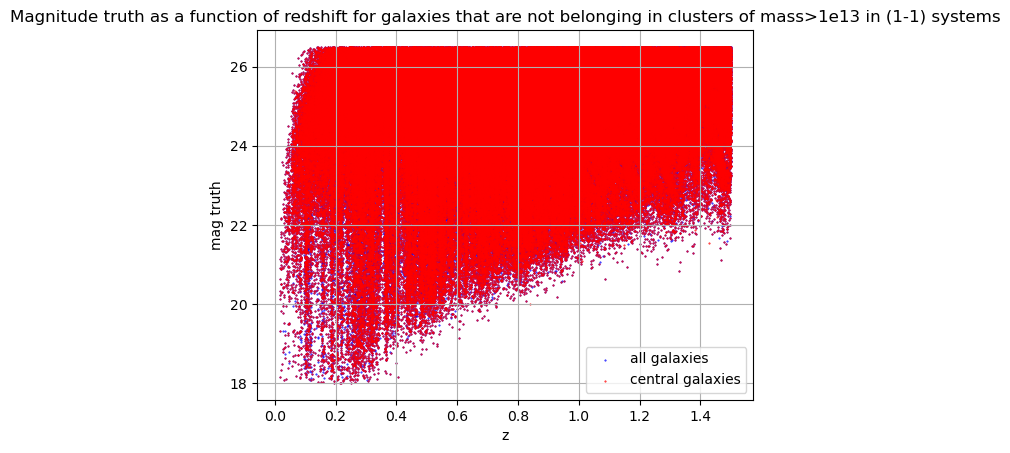

In [26]:
plt.figure()
plt.scatter(truth_data['redshift'][ind_truth_all_1_1], truth_data['mag_i'][ind_truth_all_1_1], s=0.2, label='all galaxies', color='blue')
plt.scatter(truth_data['redshift'][ind_truth_central_1_1], truth_data['mag_i'][ind_truth_central_1_1], s=0.2, label='central galaxies', color='red')
plt.xlabel('z')
plt.ylabel('mag truth')
plt.title('Magnitude truth as a function of redshift for galaxies that are not belonging in clusters of mass>1e13 in (1-1) systems')
plt.legend()
plt.grid()
plt.savefig('(1-1)_system_study_for_galaxy_out_clusters_plot/Magnitude truth as a function of redshift for galaxies that are not belonging in clusters of mass>1e13 in (1-1) systems')
plt.show()

In [27]:
print("% of (1-1) systems in the different clusters =", (len(ind_truth_all_1_1)/len(results[truth_mask][np.where((truth_data_z<z_max_cut) & (truth_data_halo_mass<halo_mass_cut_13[0]))[0]]))*100)

% of (1-1) systems in the different clusters = 60.56266890909187


In [28]:
system_1_1_mask_all_obj= np.in1d(results[object_mask]['group_id'], np.flatnonzero((n_truth_2cut_all == 1) & (n_object == 1)))

ind_object_1_1=results[object_mask][system_1_1_mask_all_obj]['row_index']

In [29]:
truth_i_mag=truth_data['mag_i'][ind_truth_all_1_1]

object_i_mag= object_data['mag_i_cModel'][ind_object_1_1]

In [30]:
def moving_average(tab, n) :
    ret = np.cumsum(tab, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

moving_average_truth_i_mag= moving_average(truth_i_mag, n=10)
moving_average_object_i_mag= moving_average(object_i_mag, n=10)

In [31]:
print(len(moving_average_truth_i_mag))
print(len(truth_i_mag))

458041
458050


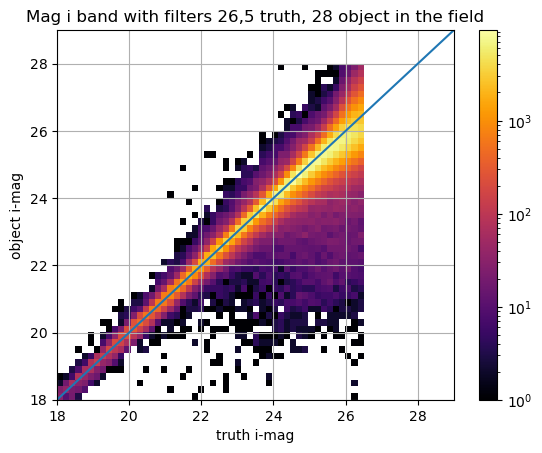

In [34]:
plt.title("Mag i band with filters 26,5 truth, 28 object in the field")
plt.hist2d(truth_i_mag, object_i_mag, bins=50, norm=mpl.colors.LogNorm(), cmap='inferno');
plt.axline([0,0], slope=1)
plt.colorbar()
plt.grid()
plt.xlim(18,29)
plt.ylim(18,29)
plt.xlabel("truth i-mag")
plt.ylabel("object i-mag")
plt.savefig('(1-1)_system_study_for_galaxy_out_clusters_plot/Mag i band with filters 26,5 truth, 28 object in the field')
plt.show()